### Load the required libraries

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import pickle
from pylab import *
%matplotlib inline

### Read TMAX data from pickle file

This file contains a dictionary with the following keys 

* ('E', (365,)) --       Sum of values for each year-day
* ('NE', (365,)) --     Number of non-NaN entries for each element of E
* ('O', (365, 365)) --   Sum of the outer products
* ('NO', (365, 365)) --  The number of non-nan elements for each position of O
* ('Cov', (365, 365)) -- Covariance matrix
* ('Var', (365,)) --     Variances (The diagonal of Cov)
* ('Mean', (365,)) --    Mean (E/NE)
* ('W', (365,)) --       Eigen-values
* ('V', (365, 365)) --   Eigen-vectors

In [2]:
Data=pickle.load(open('Weather/COV_TMAX.pickle','r'))

### Script for plotting yearly plots 

In [3]:
def YearlyPlots(T,ttl='',yl='',xl='',y=None,x=None,size=(10,7)):
    yearday=[i for i in range(1,366)]
    fig=figure(1,figsize=size,dpi=300)
    if shape(T)[0] != 365:
        raise ValueError("First dimension of T should be 365. Shape(T)="+str(shape(T)))
    plot_date(yearday,T, '-');
    # rotate and align the tick labels so they look better
    fig.autofmt_xdate()
    ylabel(yl)
    xlabel(xl)
    if y is not None:
        ylim(y)
    if x is not None:
        xlim(x)
    grid()
    title(ttl)

### Plot top-5 eigenvectors

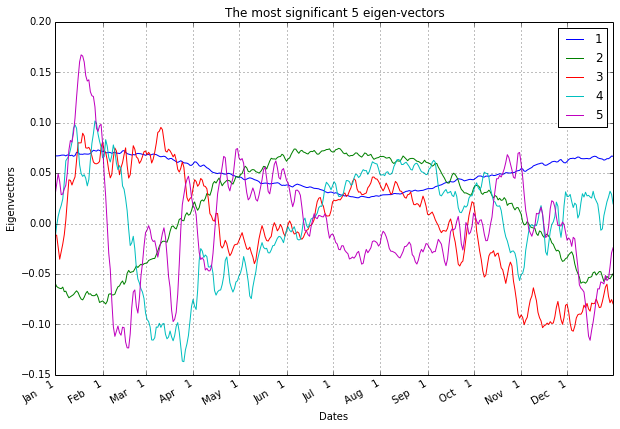

In [4]:
k=5 # number of components to show.
YearlyPlots((Data['V'][:,:k]),ttl='The most significant %d eigen-vectors'%k,yl='Eigenvectors',xl='Dates')
legend(range(1,k+1));

### Plot percentage of variance explained by top-5 eigenvectors

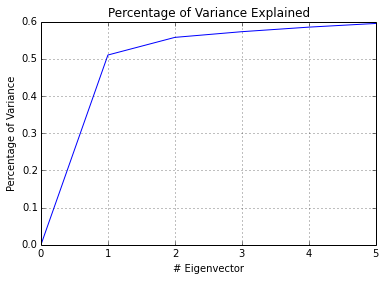

In [5]:
k=5
plot(([0,]+list(cumsum(Data['W'][:k])))/sum(Data['W']))
title('Percentage of Variance Explained')
ylabel('Percentage of Variance')
xlabel('# Eigenvector')
grid()

### Compute projection on top-3 eigenvectors

In [6]:
# Reading the sample vectors
frameheader=['station','measurement','year']+range(1,366)
YearData = pd.read_csv('Weather/SAMPLE_TMAX.csv',header=None,names=frameheader)

In [7]:
k=3
Eigen=np.matrix(Data['V'][:,:k])
matrix=np.matrix(YearData.ix[:,2:367])-Data['Mean']
matrix[isnan(matrix)]=0
Prod=matrix*Eigen

print shape(Prod)

(20000, 3)


### Insert additional information in dataframe

In [8]:
#Insert Mean and Std into dataframe

def scale_temps(Din):
    matrix=Din.iloc[:,3:]
    Dout=Din.loc[:,['station','year']+range(1,366)]
    Mean=np.mean(matrix, axis=1).values
    Dout['Mean']=Mean
    Std=np.std(matrix, axis=1).values
    Dout['Std']=Std
    return Dout

YearData=scale_temps(YearData)
YearData=YearData[['station','year','Mean','Std']+range(1,366)]

In [9]:
# Insert Coefficients for top-k eigenvectors into dataframe
k=3
for i in range(k-1,-1,-1):
    Ser=pd.Series(np.array(Prod)[:,i],index=YearData.index)
    YearData.insert(4,'V'+str(i),Ser)

In [10]:
# Insert latitude, longitude and elevation information

colspecs = [(0, 11), (11, 21), (21, 31), (31, 38),(39,41),(41,72),(72,76),(76,80),(80,86)]
stations = pd.read_fwf('Weather/ghcnd-stations_buffered.txt', colspecs=colspecs, header=None, index_col=0,
                       names=['latitude','longitude','elevation','state','name','GSNFLAG','HCNFLAG','WMOID'])

YearData=YearData.join(stations,on='station')

### Compute correlation matrix and matrix of scatterplots

In [11]:
YearData[['latitude','elevation','Mean','Std','V0','V1','V2']].corr()

,latitude,elevation,Mean,Std,V0,V1,V2
latitude,1.000000,0.050933,-0.561573,0.445277,-0.628608,0.583868,0.172747
elevation,0.050933,1.000000,-0.115618,0.101349,-0.120016,0.016747,0.170681
Mean,-0.561573,-0.115618,1.000000,-0.418703,0.888266,-0.078299,-0.066318
Std,0.445277,0.101349,-0.418703,1.000000,-0.556520,0.467508,0.122356
V0,-0.628608,-0.120016,0.888266,-0.556520,1.000000,-0.174301,-0.072943
V1,0.583868,0.016747,-0.078299,0.467508,-0.174301,1.000000,0.136650
V2,0.172747,0.170681,-0.066318,0.122356,-0.072943,0.136650,1.000000


/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


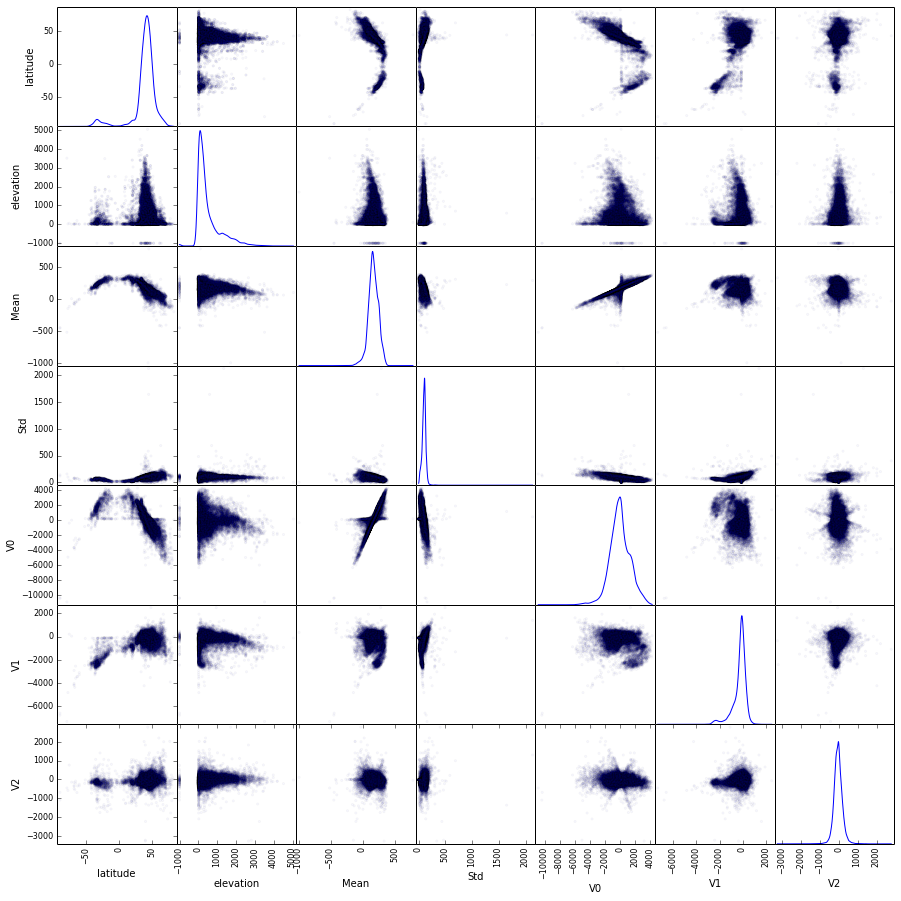

In [12]:
from pandas.tools.plotting import scatter_matrix
df = YearData.ix[:,['latitude','elevation','Mean','Std','V0','V1','V2']]
scatter_matrix(df, alpha=0.03, figsize=(15, 15), diagonal='kde');

### Reconstruction on 10 sample station-year pairs

In [13]:
def plot_reconstructions(selection,rows=2,columns=2):
    Recon=array(Eigen*Prod.transpose()+Data['Mean'][:,np.newaxis])
    plt.figure(figsize=(columns*3,rows*3),dpi=300)
    j=0;
    for i in selection:
        subplot(rows,columns,j); 
        j += 1; 
        if j>rows*columns: break
        plot(Recon[:,i])
        plot(YearData.ix[i,7:372]);
        title(YearData.ix[i,'station']+' / '+str(YearData.ix[i,'year']))
        xlim([0,365])

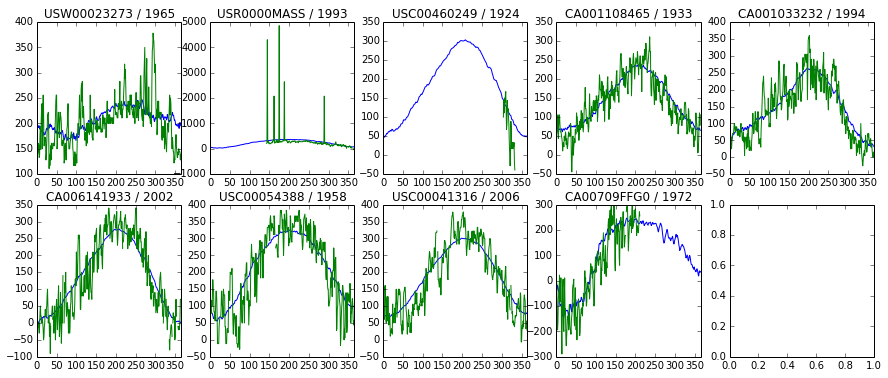

In [14]:
plot_reconstructions(range(162,180),rows=2,columns=5)